# **Maestría en Inteligencia Artificial Aplicada**

## **Curso: Inteligencia Artificial y Aprendizaje Automático**

### Tecnológico de Monterrey

### Prof Luis Eduardo Falcón Morales

## Adtividad de Semana 7

### **Campañas publicitarias en redes sociales - Modelos de Regresión**

### **Nombre:** Hiram Garcia Austria

### **Matrícula:** A00378771

### **Trabajaremos con el archivo "dataset_Facebook.csv" que encuentras en la siguiente liga:**

https://archive.ics.uci.edu/dataset/368/facebook+metrics

### **Estos datos están asociados al siguiente artículo de Moro et.al., que deberás descargar para contestar varias de las preguntas de esta actividad:**

https://www.semanticscholar.org/paper/Predicting-social-media-performance-metrics-and-of-Moro-Rita/dec55692590820754b53c916e29bb2b42c0e5104


### **NOTA: No modifiques el código, salvo en las partes que se te indica.**

In [43]:
# Puedes incluir más librerías, de ser necesario:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR

from sklearn.model_selection import RepeatedKFold, cross_validate, learning_curve
from sklearn.metrics import mean_squared_error

In [44]:
# Para no imprimir los Warnings.
warnings.filterwarnings('ignore')

## **Ejercicio 1**


### **Describe en qué consiste el método llamado de "Curvas de Aprendizaje" (Learning Curves), para monitorear el subentrenamiento o sobrbeentrenamiento de un modelo.**

#### NOTA: Puedes apoyarte en la documentación de sklearn:

https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-auto-examples-model-selection-plot-learning-curve-py



### ++++++++ Inicia la sección de agregar texto: +++++++++++


Las curvas de aprendizaje es una técnica de análisis en la cual se emplea una gráfica de lineas para visualizar el rendimiento de un modelo. Éste análisis se hace comparando el error de entrenamiento y el error de validación, para observar el tamaño del sesgo y la varianza del modelo.

Se dice que un modelo está **sobre-entrenado** cuando el error de entrenamiento es muy bajo y el error de validación es muy alto, lo que indica que el modelo no generaliza bien.

Por otro lado, un modelo está **sub-entrenado** cuando el error de entrenamiento y el error de validación son altos, lo que indica que el modelo no es lo suficientemente complejo para generalizar bien.

En cambio, un modelo está **bien entrenado** cuando el error de entrenamiento y el error de validación son bajos, lo que indica que el modelo generaliza bien.


### ++++++++ Termina la sección de agregar texto. +++++++++++

## **Ejercicio 2**

### **De acuerdo al artículo de Moro et.al., contesta las siguientes preguntas:**

*   **a. ¿Cuál es el objetivo del problema que se plantea en el artículo?**


### ++++++++ Inicia la sección de agregar texto: +++++++++++


El objetivo del articulo es crear e implementar un modelo que ayude a predecir el impacto de las publicaciones hechas en las paginas de Facebook de acuerdo a sus características.


### ++++++++ Termina la sección de agregar texto. +++++++++++


*   **b. Describe a continuación el significado de cada una de las 8 variables con la cuales trabajaremos, de acuerdo a la información de las Tablas 2 y 3 del artículo de Moro et.al.**

### ++++++++ Inicia la sección de agregar texto: +++++++++++

### VARIABLES DE ENTRADA

* **Page total likes:** Cantidad de personas a quienes les gusto la pagina.
* **Type:** Tipo de contenido, siendo uno de: enlace, foto, estatus o video.
* **Category:** Grupo al que pertenece la publicación, siendo uno de: acción, producto o inspiración.
* **Post Month:** Mes de la publicación (Enero, Febrero, etc...).
* **Post Weekday:** Día de la publicación (Domingo, Lunes, etc...).
* **Post Hour:** Hora de la publicación (0, 1, 2,..., 23).
* **Paid:** Valor booleano que indica si la empresa pagó por anunciar la publicación.

### VARIABLE DE SALIDA

* **Lifetime Post Consumers:** La cantidad de gente que hizo clic en cualquier parte de la publicación.

### ++++++++ Termina la sección de agregar texto. +++++++++++

### **En esta actividad trabajarás solamente con el ajuste de modelos, por lo que la parte de procesamiento no la debes modificar. Solo haremos unos ajustes mínimos.**

In [45]:
# Cargamos los datos:

data = pd.read_csv('./dataset_Facebook.csv', sep=';', header='infer')

# Separamos los datos de entrada y la variable de salida:
X = data.iloc[:,0:7]   # Las primeras 7 columnas son las variables de entrada.
y = data[['Lifetime Post Consumers']]   # Hay 12 variables de salida, pero solo trabajaremos con la
                                        # que se consideró la más importante en el artículo de reporte.

# Renombramos los niveles de "Type", para tener solo valores numéricos en el DataFrame:
X['Type'] = X['Type'].map({'Photo':1, 'Status':2, 'Link':3, 'Video':4})

# Particionamos en Train, Validation y Test en 60-20-20:
Xtrain, Xtv, ytrain, ytv = train_test_split(X, y, train_size=0.6, shuffle=True, random_state=5)
Xval, Xtest, yval, ytest = train_test_split(Xtv, ytv, test_size=0.5, shuffle=True, random_state=7)


print('Train:', Xtrain.shape, ytrain.shape)
print('Val:', Xval.shape, yval.shape)
print('Test:', Xtest.shape, ytest.shape)

Train: (300, 7) (300, 1)
Val: (100, 7) (100, 1)
Test: (100, 7) (100, 1)


In [46]:
Xtrain.head() # Nuestros datos de entrada

,Page total likes,Type,Category,Post Month,Post Weekday,Post Hour,Paid
92,137059,1,3,11,1,3,0.0
45,138353,3,1,12,4,3,1.0
313,124940,1,3,6,7,3,1.0
46,138353,2,1,12,3,11,0.0
185,134879,1,1,9,1,10,0.0


In [47]:
Xtrain.describe().T   # Veamos alguna descripción como datos numéricos del conjunto de entrenamiento.
                      # En particular, las desviaciones estándar son muestrales.

,count,mean,std,min,25%,50%,75%,max
Page total likes,300.0,123511.376667,16211.773474,81370.0,113028.00,130195.5,136393.0,139441.0
Type,300.0,1.216667,0.580959,1.0,1.00,1.0,1.0,4.0
Category,300.0,1.896667,0.849546,1.0,1.00,2.0,3.0,3.0
Post Month,300.0,7.106667,3.306316,1.0,4.00,7.0,10.0,12.0
Post Weekday,300.0,4.180000,2.015226,1.0,2.75,4.0,6.0,7.0
Post Hour,300.0,7.546667,4.348662,1.0,3.00,8.0,11.0,22.0
Paid,299.0,0.290970,0.454971,0.0,0.00,0.0,1.0,1.0


In [48]:
ytrain.describe().T   # lo mismo para la variable de salida.

,count,mean,std,min,25%,50%,75%,max
Lifetime Post Consumers,300.0,827.986667,1009.102992,9.0,321.25,543.5,1008.75,11328.0


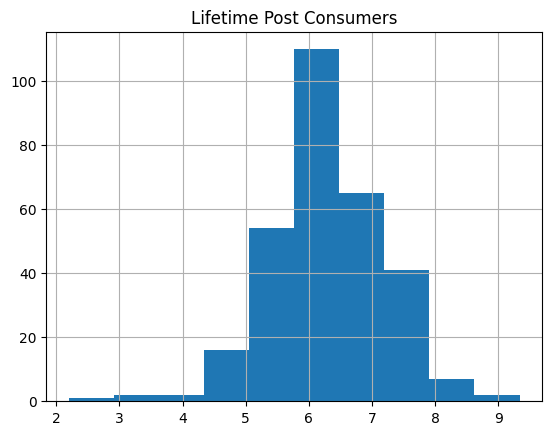

In [49]:
ytrainlog = np.log(ytrain)   # Recordemos que nuestra variable de salida en un problema
ytrainlog.hist();            # de Regresión se recomienda que esté aproximadamente
                             # acampanada, por lo que la ajustaremos con el logaritmo
                             # natural como primera aproximación.

In [50]:
# y procedemos de la misma manera con Val y test:
yvallog = np.log(yval)
ytestlog = np.log(ytest)

In [51]:
# Aplicaremos lo mínimo de transformaciones, en particular para datos perdidos:
num_pipe = Pipeline(steps = [('numImp', SimpleImputer(strategy='median')),
                             ])
num_pipe_nombres = [0]   # ['Page total likes']


# Las ordinales las identificamos como tales:
ord_pipe = Pipeline(steps =  [('OrdImp', SimpleImputer(strategy='most_frequent')),
                              ('Ordfun', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1 ))
                              ])
ord_pipe_nombres = [3,4,5]   # ['Post Month', 'Post Weekday', 'Post Hour']

# Las nominales las transformamos con One-Hot-Encoder:
nom_pipe = Pipeline(steps = [('ohe', OneHotEncoder(drop='first',
                                                   handle_unknown='ignore',
                                                   ))])
nom_pipe_nombres = [1,2,6]   # ['Type', 'Category', 'Paid']


# Conjuntamos las transformaciones que aplicaremos:
columnasTransformer = ColumnTransformer(transformers = [('numpow', num_pipe, num_pipe_nombres),
                                                        ('catOrd', ord_pipe, ord_pipe_nombres),
                                                        ('catNom', nom_pipe, nom_pipe_nombres)
                                                        ],
                                        remainder='passthrough')


In [52]:
# Solo para saber la nueva cantidad de columnas después de las trasnformaciones:

XtrainT = columnasTransformer.fit_transform(Xtrain)  # Ajustamos con Train...
print('Variables de entrada original:', Xtrain.shape)
print('Variables de entrada transformadas:', XtrainT.shape)

Variables de entrada original: (300, 7)
Variables de entrada transformadas: (300, 11)


In [53]:
# El valor de RMSE-Root-Mean-Square-Error, se utiliza para medir el desempeño
# mínimo que debiera obtener un modelo de regresión, es decir, este valor
# se toma usualmente como el valor del modelo subentrenado y se compara generalmente
# con el valor de la desviación estándar de la variable de salida, ya sea que la
# estés tomando de manera original o con los datos transformados.
# Veamos el valor de ambas:

print('Desv-Est y-original: %.3f' % ytrain.values.std(ddof=1))      # Usemos la desviación estándar muestral ajustando.
print('Desv-Est y-logaritmo: %.3f' % ytrainlog.values.std(ddof=1))        # los grados de libertad.

Desv-Est y-original: 1009.103
Desv-Est y-logaritmo: 0.907


#### **NOTA:**
#### **Estricamente, desde el punto de vista matemático las desviaciones estándar que uno calcula deben ser las muestrales, es decir, std(ddof=1). Sin embargo, en la práctica es muy común usar la función con su valor predeterminado que es ddof=0 y que se traduce a calcular la desviación estándar poblacional. Repito, en la práctica suele pasarse por alto este ajuste porque cuando se tienen datos de miles o más regitros, la diferencia entre el resultado problacional y el muestral es mínima. En esta actividad lo pongo solamente para recordarlo y en dado caso cuando tengas menos de 100 registros sí hacer este ajuste, porque la diferencia entre ambos ya podría ser importante.**

In [54]:
# Como se va a utilizar Validación-Cruzada, concatenamos los conjuntos de entrenamiento y validación
# en uno nuevo conjunto aumentado que llamaremos trainval para utilizar como entrenamiento:

Xtrainval = np.concatenate((Xtrain, Xval), axis=0)
ytrainvallog = np.concatenate((ytrainlog, yvallog), axis=0)

## **Ejercicio 3**


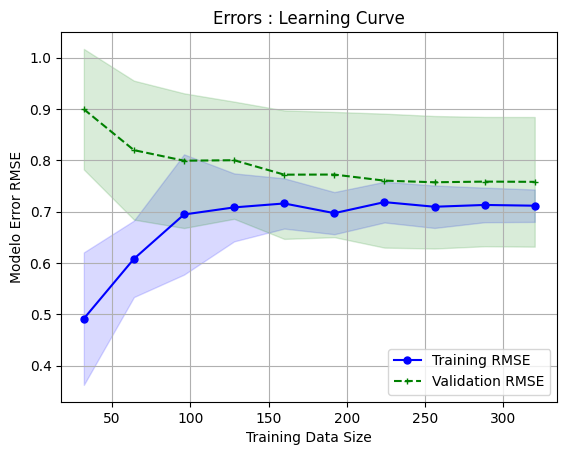

In [55]:
# Al ejecutar las siguientes líneas de código determina si el modelo de
# Bosque Aleatorio con sus valores de hiperparámetros predeterminadas está
# Subentrenado o Sobreentrenado. De ser así, busca los valores de sus
# hiperparámetros que consideres más adecuados para que ya no
# esté sub-o-sobreentrenado:


# ++++++++++++++ Incluye aquí tus ajustes ++++++++++++++++++++++++++++++

# elmodelo_RF = RandomForestRegressor()
elmodelo_RF = RandomForestRegressor(
    max_depth=3,
    min_samples_split=2,
    n_estimators=100,
    random_state=42,
    min_samples_leaf=1,
    max_features='log2',
    n_jobs=-1,
    criterion='squared_error'
)

# +++++++++++++ Termina sección de realizar ajustes +++++++++++++++++++++



mipipe = Pipeline(steps=[('ct',columnasTransformer),('m', elmodelo_RF)])

train_sizes, train_scores, val_scores = learning_curve(estimator=mipipe,
                                                        X=Xtrainval,
                                                        y=np.ravel(ytrainvallog),
                                                        cv=5,
                                                        train_sizes= np.linspace(0.1, 1.0, 10),
                                                        scoring= 'neg_mean_squared_error',  # error MSE
                                                        n_jobs=-1)



# Calculamos los promedios y desviación estándar de entrenamiento para RMSE,
# como tenemos los de MSE, debemos obtener su raíz cuadrada. El negativo es porque
# sklearn nos devuelve en realidad el negativo del Error Cuadrático Medio MSE:

rmse_train_scores = np.sqrt(-train_scores)
rmse_val_scores = np.sqrt(-val_scores)

train_mean = np.mean(rmse_train_scores, axis=1)
train_std = np.std(rmse_train_scores, axis=1, ddof=1)   # aquí también hacemos el ajuste de la desviación estándar muestral.
val_mean = np.mean(rmse_val_scores, axis=1)
val_std = np.std(rmse_val_scores, axis=1, ddof=1)


plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training RMSE')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

plt.plot(train_sizes, val_mean, color='green', marker='+', markersize=5, linestyle='--', label='Validation RMSE')
plt.fill_between(train_sizes, val_mean + val_std, val_mean - val_std, alpha=0.15, color='green')

plt.title('Errors : Learning Curve')
plt.xlabel('Training Data Size')
plt.ylabel('Modelo Error RMSE')
plt.grid()
plt.legend(loc='lower right')
plt.show()


In [127]:
RF = RandomForestRegressor()

# Hiperparámetros a probar
params_rf = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [3],
    'min_samples_split': [2, 5, 15],
    # 'min_samples_leaf': [1, 5, 15],
    # 'bootstrap': [True, False],
    'random_state': [42],
    # 'warm_start': [False, True],
    # 'ccp_alpha': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5],
    'min_samples_leaf': [1],
    'max_features': ['log2'],
    'n_jobs': [-1],
    'criterion': ['squared_error']
}

# Validación cruzada
# grid_search_rf = GridSearchCV(estimator=RF, param_grid=params_rf, cv=5, scoring='neg_mean_squared_error')
grid_search_rf = GridSearchCV(estimator=RF, param_grid=params_rf, cv=5, scoring='neg_root_mean_squared_error')

# Entrenamiento
grid_search_rf.fit(Xtrainval, np.ravel(ytrainvallog))

# Resultados en forma de lista
print(f'Mejores parámetros RF: {grid_search_rf.best_params_}')
print(f'Mejor error RMSE RF: {grid_search_rf.best_score_}')

Mejores parámetros RF: {'criterion': 'squared_error', 'max_depth': 3, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50, 'n_jobs': -1, 'random_state': 42}
Mejor error RMSE RF: -0.7943553601743515


In [57]:
# Una vez que verifiquemos que no está sobreentrenado o subentrenado el modelo,
# podemos calcular el RMSE del mejor ajuste con los datos de Prueba.
# Incluye los valores de tus mejores hiperparámetros encontrados del RandomForest:

# ++++++++++++++ Incluye aquí tus ajustes ++++++++++++++++++++++++++++++

elmodelo_RF = RandomForestRegressor(
    max_depth=3,
    min_samples_split=2,
    n_estimators=100,
    random_state=42,
    min_samples_leaf=1,
    max_features='log2',
    n_jobs=-1,
    criterion='squared_error'
)

# +++++++++++++ Termina sección de realizar ajustes +++++++++++++++++++++

mipipe = Pipeline(steps=[('ct',columnasTransformer),('m', elmodelo_RF)])
mipipe.fit(pd.DataFrame(Xtrainval, columns=Xtrain.columns), np.ravel(ytrainvallog))
yhattest_RF = mipipe.predict(Xtest)

print('Error RSME(Test) de Random Forest: %.3f' % np.sqrt(mean_squared_error(np.ravel(ytestlog), yhattest_RF)))

Error RSME(Test) de Random Forest: 0.772


## **Ejercicio 4**

### **Repite el mismo proceso del Ejercicio 3 anterior para obtener los hiperparámetros que nos lleven a casos de modelos no subentrenados o sobreentrenaos, en cada uno de los siguientes casos:**

*   **a. Extreme Gradient Boost XGBoost**
*   **b. Máquina de Vector Soporte SVM**
*   **c. Red Neuronal Perceptrón Multicapa MLP**

In [130]:
# Incluye a continuación las celdas y líneas de código que consideres necesarias para
# responder el Ejercicio 4.

# Función para dibujar la curva de aprendizaje en un eje específico
def graficaCurvaAprendizaje(estimator, title, ax):
    ax.set_title('Curva de aprendizaje con ' + title)
    ax.set_xlabel('Tamaño del conjunto de entrenamiento')
    ax.set_ylabel('Error RMSE')

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, Xtrainval, np.ravel(ytrainvallog), cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10), scoring='neg_mean_squared_error'
    )
    train_scores = np.sqrt(-train_scores)
    test_scores = np.sqrt(-test_scores)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1, ddof=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1, ddof=1)
    
    ax.grid()
    ax.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='green')
    ax.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='blue')
    ax.plot(train_sizes, train_scores_mean, '+', color='green', label='Entrenamiento RMSE', linestyle='--')
    ax.plot(train_sizes, test_scores_mean, 'o', color='blue', label='Validación RMSE', linestyle='-')
    ax.legend(loc='best')

# Función para alinear las tres curvas en una figura de 3 columnas
def grafica3Curvas(estimator1, title1, estimator2, title2, estimator3, title3):
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    graficaCurvaAprendizaje(estimator1, title1, axs[0])
    graficaCurvaAprendizaje(estimator2, title2, axs[1])
    graficaCurvaAprendizaje(estimator3, title3, axs[2])
    plt.tight_layout()
    plt.show()

In [121]:
# Encontrando hiperparámetros para XGBoost
XGB = XGBRegressor()

# Hiperparámetros a probar
params_xgb = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [2, 4],
    'min_child_weight': [20],
    'gamma': [0.2, 1, 1.5],
    'learning_rate': [0.005],
    'subsample': [0.5, 0.8],
    # 'colsample_bytree': [0.2, 0.5, 0.8],
    'reg_alpha': [50.0],
    'reg_lambda': [50.0],
    'objective': ['reg:squarederror'],
    'eval_metric': ['rmse'],
}

# Validación cruzada
grid_search_xgb = GridSearchCV(estimator=XGB, param_grid=params_xgb, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)

# Entrenamiento
grid_search_xgb.fit(Xtrainval, np.ravel(ytrainvallog))

# Resultados mejores hiperparámetros
print(f'Mejores hiperparámetros para XGB: {grid_search_xgb.best_params_}')
print(f'Mejor RMSE con XGB: {grid_search_xgb.best_score_}')

Mejores hiperparámetros para XGB: {'eval_metric': 'rmse', 'gamma': 0.2, 'learning_rate': 0.005, 'max_depth': 2, 'min_child_weight': 20, 'n_estimators': 1000, 'objective': 'reg:squarederror', 'reg_alpha': 50.0, 'reg_lambda': 50.0, 'subsample': 0.8}
Mejor RMSE con XGB: -0.8958949644150049


In [70]:
# Encontrando hiperparámetros para Maquinas de Soporte Vectorial (SVM)
SVM = SVR()

# Hiperparámetros a probar, necesitan prefijo 'm__' para funcionar con el pipeline
params_svm = {
    'm__C': [0.1, 0.3, 1, 10, 100],
    'm__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'm__degree': [2, 3, 4],
    'm__gamma': ['scale', 'auto'],
    'm__epsilon': [0.1, 0.2, 0.3],
    'm__max_iter': [10, 100, 500, 1000],
}

# Pipeline para SVM para quitar valores nulos
pipeline_svm = Pipeline(steps=[('ct',columnasTransformer),('m', SVM)])

# Validación cruzada
grid_search_svm = GridSearchCV(estimator=pipeline_svm, param_grid=params_svm, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)

# Entrenamiento
grid_search_svm.fit(Xtrainval, np.ravel(ytrainvallog))

# Resultados mejores hiperparámetros
print(f'Mejores hiperparámetros para SVM: {grid_search_svm.best_params_}')
print(f'Mejor RMSE con SVM: {grid_search_svm.best_score_}')

Mejores hiperparámetros para SVM: {'m__C': 100, 'm__degree': 2, 'm__epsilon': 0.3, 'm__gamma': 'scale', 'm__kernel': 'rbf', 'm__max_iter': 500}


In [71]:
# Encontrando hiperparámetros para Red Neuronal Perceptrón Multicapa (MLP)
MLP = MLPRegressor()

# Hiperparámetros a probar, necesitan prefijo 'm__' para funcionar con el pipeline
params_mlp = {
    'm__hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'm__activation': ['tanh', 'relu'],
    'm__solver': ['adam'],
    'm__alpha': [0.0001, 0.05],
    'm__learning_rate': ['constant','adaptive'],
    'm__max_iter': [200, 500],
    'm__random_state': [42],
}

# Pipeline para MLP para quitar valores nulos
pipeline_mlp = Pipeline(steps=[('ct',columnasTransformer),('m', MLP)])

# Validación cruzada
grid_search_mlp = GridSearchCV(estimator=pipeline_mlp, param_grid=params_mlp, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)

# Entrenamiento
grid_search_mlp.fit(Xtrainval, np.ravel(ytrainvallog))

# Resultados mejores hiperparámetros
print(f'Mejores hiperparámetros para MLP: {grid_search_mlp.best_params_}')
print(f'Mejor RMSE con MLP: {grid_search_mlp.best_score_}')

Mejores hiperparámetros para MLP: {'m__activation': 'tanh', 'm__alpha': 0.0001, 'm__hidden_layer_sizes': (100,), 'm__learning_rate': 'constant', 'm__max_iter': 200, 'm__random_state': 42, 'm__solver': 'adam'}


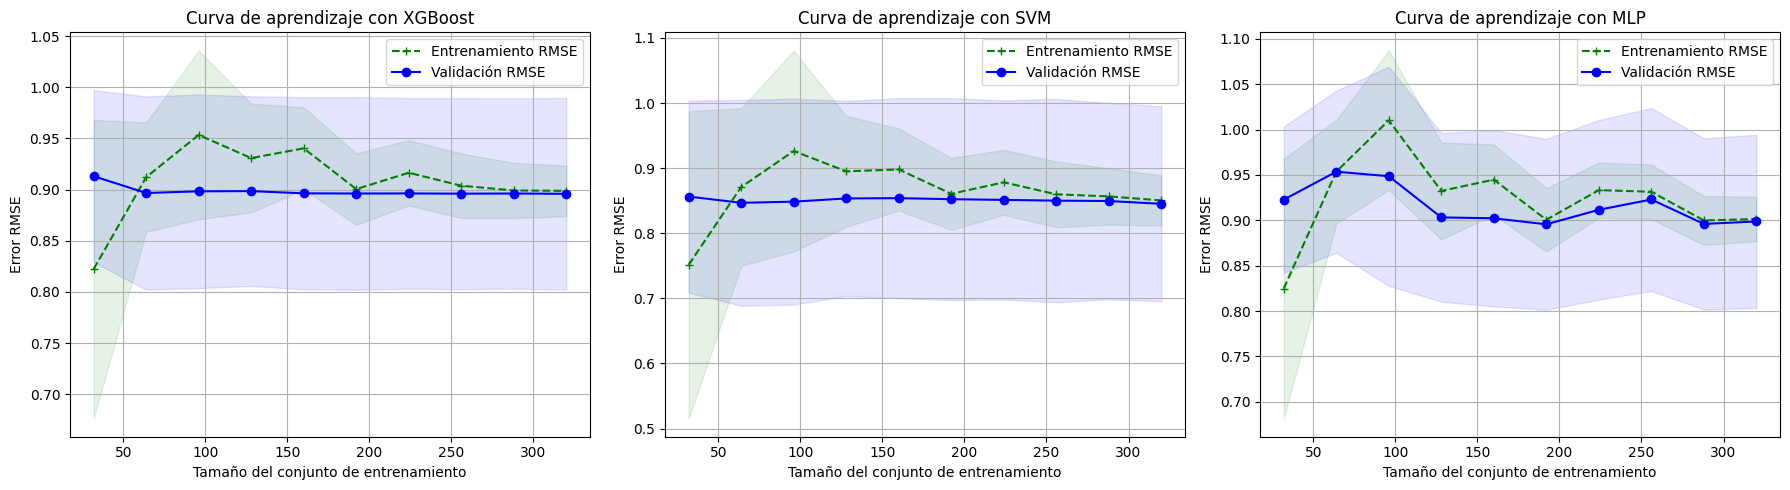

Mejor RMSE con XGB: -0.8958949644150049
Mejor RMSE con SVM: -0.845204990198759
Mejor RMSE con MLP: -0.8987780919036312


In [129]:
# Gráficas de Curva de aprendizaje
grafica3Curvas(
    grid_search_xgb.best_estimator_, 'XGBoost',
    grid_search_svm.best_estimator_, 'SVM',
    grid_search_mlp.best_estimator_, 'MLP'
)

# Mejores RMSE
print(f'Mejor RMSE con XGB: {grid_search_xgb.best_score_}')
print(f'Mejor RMSE con SVM: {grid_search_svm.best_score_}')
print(f'Mejor RMSE con MLP: {grid_search_mlp.best_score_}')

# **Ejercicio 5**

### **Incluye tus conclusiones finales de la Actividad.**
### **En particular indica cuál consideras que fue el mejor modelo obtenido.**

### ++++++++ Inicia la sección de agregar texto: +++++++++++


## **Conclusiones**

Después de evaluar diversos modelos, con diferentes hiperparámetros y realizar la validación cruzada para cada uno de ellos, podemos comparar las gráficas de curva de aprendizaje y los errores RMSE obtenidos para cada uno de los modelos.

Vemos que ninguno esta sobre-entrenado o sub-entrenado, ya que los errores de validación y entrenamiento son muy cercanos.

Para determinar cual es el mejor modelo, debemos tomar en cuenta que en problemas de regresión como este, un valor de RMSE más bajo indica que el modelo tiene un menor error en sus predicciones, representando un mejor ajuste y una mayor precisión. Por lo tanto, de acuerdo a los resultados obtenidos en la validación cruzada, los modelos de **Red Neuronal Perceptrón Multicapa (MLP) y el XGBoost** son los que obtienen el mejor desempeño con un RMSE de -89.87% y -89.58% respectivamente.

Mientras que el modelo con el peor desempeño es el Bosque Aleatorio (Random Forest) con un -77.2%.

De esta manera podemos concluir que el **modelo de MLP es el que mejor se ajusta a los datos** y es el más adecuado para predecir el número de consumidores de un post en Facebook.


### ++++++++ Termina la sección de agregar texto. +++++++++++

>> **Fin de la Actividad de la Semana 7**